# Training and testing model

### Importing relevant Libararies, Objects and Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
from torchsummary import summary
from sklearn.metrics import r2_score

from train import TrainingAlgorithm
from model import model
from utils import load_train_val_loaders

### Training Model

Epoch 1/100 - train MSE: 0.5210 - val MSE: 0.2252 - val MAE: 0.3666
Epoch 2/100 - train MSE: 0.2500 - val MSE: 0.1774 - val MAE: 0.3337
Epoch 3/100 - train MSE: 0.2116 - val MSE: 0.1165 - val MAE: 0.2610
Epoch 4/100 - train MSE: 0.1257 - val MSE: 0.0506 - val MAE: 0.1562
Epoch 5/100 - train MSE: 0.0855 - val MSE: 0.0495 - val MAE: 0.1559
Epoch 6/100 - train MSE: 0.1030 - val MSE: 0.0475 - val MAE: 0.1458
Epoch 7/100 - train MSE: 0.0751 - val MSE: 0.0477 - val MAE: 0.1476
Epoch 8/100 - train MSE: 0.0639 - val MSE: 0.0364 - val MAE: 0.1321
Epoch 9/100 - train MSE: 0.0534 - val MSE: 0.0365 - val MAE: 0.1353
Epoch 10/100 - train MSE: 0.0515 - val MSE: 0.0347 - val MAE: 0.1311
Epoch 11/100 - train MSE: 0.0450 - val MSE: 0.0304 - val MAE: 0.1233
Epoch 12/100 - train MSE: 0.0465 - val MSE: 0.0382 - val MAE: 0.1346
Epoch 13/100 - train MSE: 0.0427 - val MSE: 0.0261 - val MAE: 0.1152
Epoch 14/100 - train MSE: 0.0421 - val MSE: 0.0312 - val MAE: 0.1251
Epoch 15/100 - train MSE: 0.0367 - val MSE:

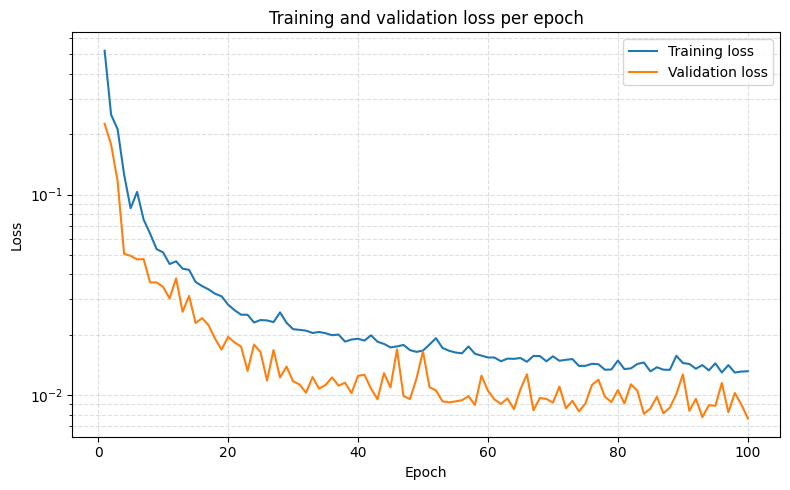

In [2]:
train_loader, val_loader = load_train_val_loaders("data")

m = model(load_weights=False)
num_epochs = 100
train_losses, val_losses = TrainingAlgorithm(
    m, train_loader, val_loader, num_epochs=num_epochs, patience=10, device="cpu"
)

epochs = np.arange(1, len(train_losses)+1)

# Plot loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Training loss")
plt.plot(epochs, val_losses, label="Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale("log")
plt.title("Training and validation loss per epoch")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

### R2 score

Loaded pretrained weights from: c:\Users\oskar\ML_course_homeworks\ML4Physics_homework2\model_weights.pth
Validation MSE: 0.007704
Validation R^2: 0.9758


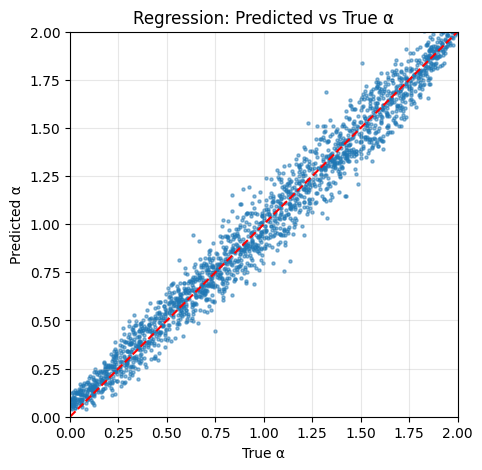

In [3]:
device = "cpu"  # or "cuda" if you used GPU

# 1) Load trained model (or reuse the one you trained)
m_eval = model(load_weights=True)
m_eval.to(device)
m_eval.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for X_val, y_val in val_loader:
        X_val = X_val.to(device).float()
        y_val = y_val.to(device).float()

        # continuous regression predictions
        preds = m_eval.pred(X_val)        # shape (batch,)
        preds = preds.view(-1)
        y_val = y_val.view(-1)

        all_preds.append(preds.cpu())
        all_targets.append(y_val.cpu())

all_preds = torch.cat(all_preds)     # shape (N_val,)
all_targets = torch.cat(all_targets) # shape (N_val,)

# 2) MSE
mse = torch.mean((all_preds - all_targets) ** 2).item()

# 3) R^2 (need numpy arrays)
r2 = r2_score(all_targets.numpy(), all_preds.numpy())

print(f"Validation MSE: {mse:.6f}")
print(f"Validation R^2: {r2:.4f}")

# 4) Scatter plot true vs predicted alpha
plt.figure(figsize=(5,5))
plt.scatter(all_targets, all_preds, s=5, alpha=0.5)
plt.plot([0, 2], [0, 2], 'r--')  # perfect prediction line
plt.xlim(0, 2)
plt.ylim(0, 2)
plt.xlabel("True α")
plt.ylabel("Predicted α")
plt.title("Regression: Predicted vs True α")
plt.grid(True, alpha=0.3)
plt.show()
plt.show()

### Testing submission

model.pred() needs to take the same input as the training data and output must be a one-dimensional tensor with the prediction of each input sample.

In [4]:
m_test = model() 
X = torch.load("data\input_data.pt")

y = m_test.pred(X)
print(y)

Loaded pretrained weights from: c:\Users\oskar\ML_course_homeworks\ML4Physics_homework2\model_weights.pth
tensor([0.3025, 1.3509, 1.0524,  ..., 0.4886, 0.0678, 1.6434])


### Summary of parameters

In [5]:
m_sum = model(load_weights=False) 
summary(m_sum, input_size=(200, ), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 16, 200]              96
         MaxPool1d-2              [-1, 16, 100]               0
            Conv1d-3              [-1, 32, 100]           2,592
         MaxPool1d-4               [-1, 32, 50]               0
            Conv1d-5               [-1, 64, 50]          10,304
         MaxPool1d-6               [-1, 64, 25]               0
 AdaptiveAvgPool1d-7                [-1, 64, 1]               0
            Linear-8                   [-1, 64]           4,160
           Dropout-9                   [-1, 64]               0
           Linear-10                    [-1, 1]              65
Total params: 17,217
Trainable params: 17,217
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.11
Params size (MB): 0.07
Estimated Tot